#### Important Notebook

This notebook analyses the crosstabs calculated at matrix level

In [35]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import itertools

In [2]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

In [3]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

#### Crosstabs config

In [29]:
config_file = '../src/bill_passage/postmodeling/crosstabs_config.yaml'
with open(config_file) as f:
    config = yaml.safe_load(f)
config

{'output': {'schema': 'test_results', 'table': 'crosstabs'},
 'thresholds': {'rank_abs': [100],
  'rank_pct': [10],
  'score_bins': {'will_not_pass': [0, 0.1],
   'unlikely': [0.1, 0.35],
   'coin-toss': [0.35, 0.55],
   'likely': [0.55, 0.7],
   'very_likely': [0.7, 0.9],
   'will_pass': [0.9, 1.0]}},
 'model_ids': [16465, 16592, 16722, 16850],
 'project_path': 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_lt'}

#### Analyzing bins for each model

In [87]:
model_id = config['model_ids'][1]
bins = list(config['thresholds']['score_bins'].keys())
table_name = config['output']['table']

print(model_id, table_name, bins)

16592 crosstabs ['will_not_pass', 'unlikely', 'coin-toss', 'likely', 'very_likely', 'will_pass']


**Mean ratios**

We look at mean ratios where bins with counts > 0

In [88]:
q = """
    select 
        model_id,
        train_end_time,
        related_likelihood_bins,
        max(value) as value
    from test_results.{table_name}
    where metric='count' 
    and model_id={model_id}
    and value > 0
    group by 1, 2, 3
""".format(
    table_name=table_name,
    model_id=model_id
)

counts = pd.read_sql(q, db_conn)

In [89]:
counts

,model_id,train_end_time,related_likelihood_bins,value
0,16592,2018-06-01,coin-toss,8285.0
1,16592,2018-06-01,likely,9891.0
2,16592,2018-06-01,unlikely,18846.0
3,16592,2018-06-01,very_likely,5435.0
4,16592,2018-06-01,will_not_pass,24432.0
5,16592,2018-06-01,will_pass,456.0


#### Mean Ratios

In [90]:
def get_mean_ratio(model_id, bin1, bin2):
    q = """
        select 
            * 
        from test_results.crosstabs
        where metric='mean_ratio' 
        and model_id={model_id}
        and related_likelihood_bins = '{bin1}/{bin2}'
        and value < 10000000
        and feature_name not like '%state%' -- Excluding the state features
        order by related_likelihood_bins, value desc
    """.format(model_id=model_id, bin1=bin1, bin2=bin2)
    
    return pd.read_sql(q, db_conn)

def plot_mean_ratio(data, bin1, bin2, num_features_to_plot=30):
    fig, ax = plt.subplots(figsize=(6, 10))
    sns.barplot(
        data=mean_ratios[:num_features_to_plot],
        x = 'value',
        y='feature_name',
        ax=ax,
        color='royalblue'
    )
    ax.set_xlabel('mean ratio')
    ax.set_title('Ratio of Feature means -- {} / {}'.format(bin1, bin2))
    sns.despine()

#### Two Extremes

In [91]:
bin1 = 'will_pass'
bin2 = 'will_not_pass'
mean_ratios = get_mean_ratio(model_id, bin1, bin2)
# plot_mean_ratio(mean_ratios, bin1, bin2)
mean_ratios[:30]

,model_id,train_end_time,metric,related_likelihood_bins,feature_name,value
0,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,bl_sp_entity_id_all_sponsors_frac_uc_max,18.975876
1,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,evnt_cts_entity_id_2week_action_count,15.524496
2,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,evnt_cts_entity_id_1month_action_count,14.165278
3,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,evnt_cts_entity_id_1week_action_count,13.781309
4,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,bl_stat_entity_id_all_bill_type_CR_max,13.200610
5,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,bl_stat_entity_id_all_bill_type_R_max,12.308677
6,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,txt_entity_id_1week_doc_id_count,12.240480
7,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,txt_entity_id_2week_doc_id_count,10.103024
8,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,evnt_cts_entity_id_2week_important_sum,9.257096
9,16592,2018-06-01,mean_ratio,will_pass/will_not_pass,evnt_cts_entity_id_1week_important_sum,9.133253


#### What moves bills move from "coin-toss" to a "will pass"?

In [93]:
bin1 = 'will_pass'
bin2 = 'coin-toss'

mean_ratios = get_mean_ratio(model_id, bin1, bin2)
# plot_mean_ratio(mean_ratios, bin1, bin2, 40)
mean_ratios[:30]

,model_id,train_end_time,metric,related_likelihood_bins,feature_name,value
0,16592,2018-06-01,mean_ratio,will_pass/coin-toss,bl_sp_entity_id_all_sponsors_frac_lc_max,12.354825
1,16592,2018-06-01,mean_ratio,will_pass/coin-toss,txt_entity_id_1week_doc_id_count,8.138507
2,16592,2018-06-01,mean_ratio,will_pass/coin-toss,bl_stat_entity_id_all_bill_type_CR_max,7.267544
3,16592,2018-06-01,mean_ratio,will_pass/coin-toss,txt_entity_id_2week_doc_id_count,7.177599
4,16592,2018-06-01,mean_ratio,will_pass/coin-toss,txt_entity_id_1month_doc_id_count,4.522221
5,16592,2018-06-01,mean_ratio,will_pass/coin-toss,bl_sp_entity_id_all_sponsors_frac_uc_max,2.998744
6,16592,2018-06-01,mean_ratio,will_pass/coin-toss,evnt_cts_entity_id_1month_action_count,2.846220
7,16592,2018-06-01,mean_ratio,will_pass/coin-toss,evnt_cts_entity_id_2week_action_count,2.341271
8,16592,2018-06-01,mean_ratio,will_pass/coin-toss,bl_stat_entity_id_all_introduced_body_H_max,2.286770
9,16592,2018-06-01,mean_ratio,will_pass/coin-toss,evnt_cts_entity_id_1month_important_sum,2.196979


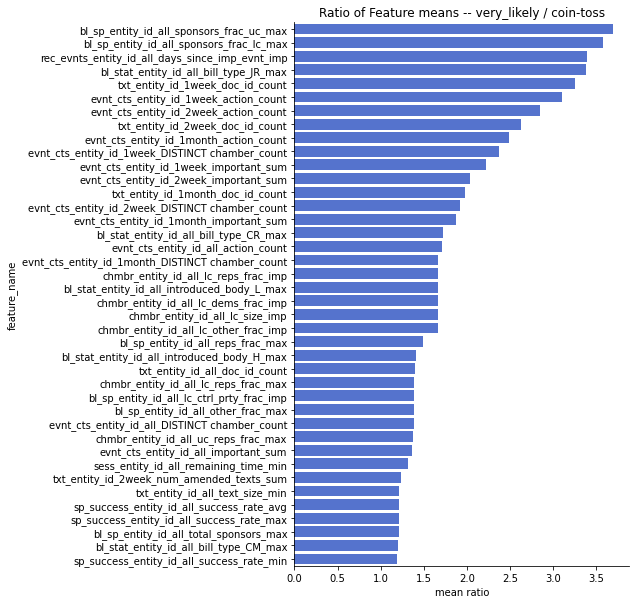

In [68]:
bin1 = 'very_likely'
bin2 = 'coin-toss'

mean_ratios = get_mean_ratio(model_id, bin1, bin2)
plot_mean_ratio(mean_ratios, bin1, bin2, 40)

Features that seem to pull up:
- Number of sponsors with respect to the chamber size
- Days since the last event is missing?*
- Joint resolutions (doesnt mean much)
- Number of bill versions (doc id count) is higher
- Number of events (action counts) is higher
- events happening in different chambers is higher
- Sponsor success rates slightly higher

#### Coin-toss and will not pass?

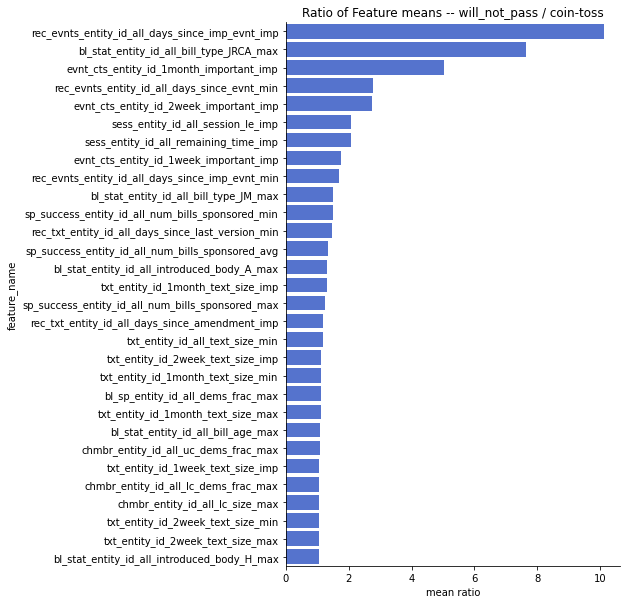

In [66]:
bin1 = 'will_not_pass'
bin2 = 'coin-toss'

mean_ratios = get_mean_ratio(model_id, bin1, bin2)
plot_mean_ratio(mean_ratios, bin1, bin2, 30)

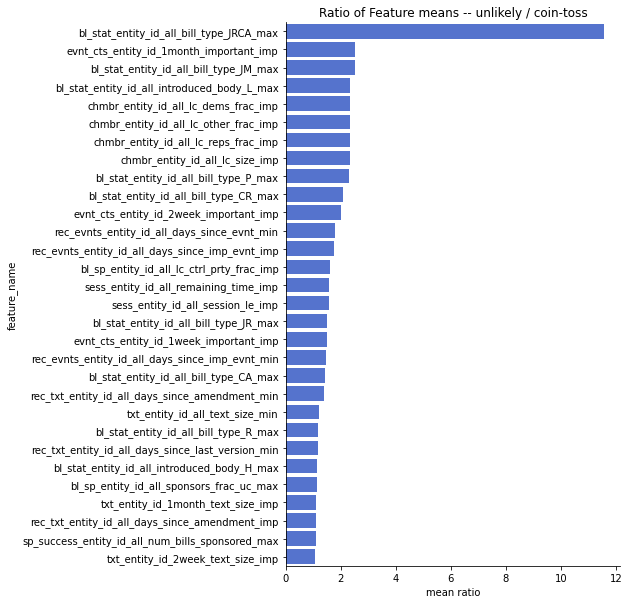

In [69]:
bin1 = 'unlikely'
bin2 = 'coin-toss'

mean_ratios = get_mean_ratio(model_id, bin1, bin2)
plot_mean_ratio(mean_ratios, bin1, bin2, 30)

#### Likely vs unlikely

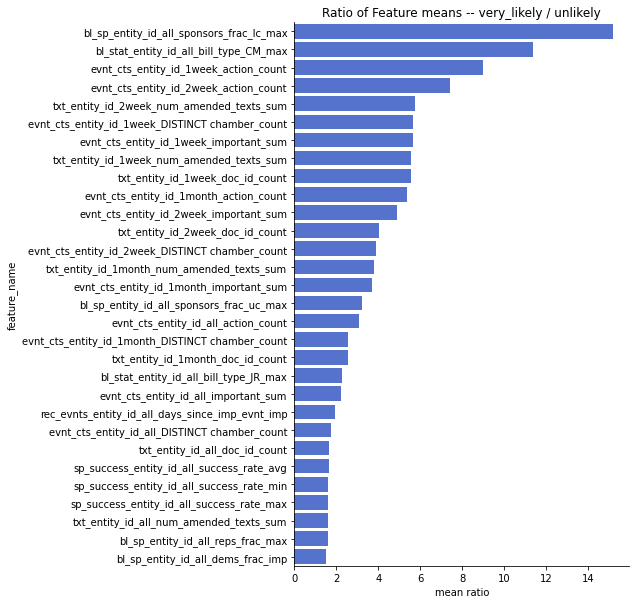

In [70]:
bin1 = 'very_likely'
bin2 = 'unlikely'

mean_ratios = get_mean_ratio(model_id, bin1, bin2)
plot_mean_ratio(mean_ratios, bin1, bin2, 30)

### Inspecting a feature over time

In [94]:
feature_name = 'bl_sp_entity_id_all_sponsors_frac_lc_max'

q = """
    select 
        *
    from test_results.crosstabs
    where metric='mean'
    and feature_name = '{}'
""".format(feature_name)

feature_means = pd.read_sql(q, db_conn)

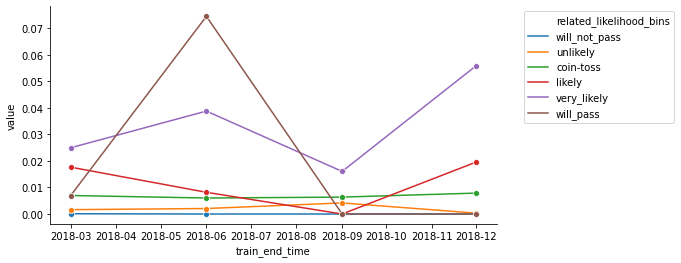

In [95]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    data=feature_means,
    x='train_end_time',
    y='value',
    hue='related_likelihood_bins',
    marker='o'
)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))